In [1]:
import sys
sys.path.append("../")

In [23]:
import os
import logging
from typing import Callable, List
from collections import Counter

import numpy as np
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

from src.utils.logger import get_logger
from src.surrogate.lime import LimeTextSummarizer

import matplotlib.pyplot as plt

In [3]:
_ = get_logger(logging.ERROR)

## Download Dataset

In [4]:
dataset = fetch_olivetti_faces()

In [5]:
dataset.data.shape

(400, 4096)

In [6]:
dataset.images.shape

(400, 64, 64)

In [7]:
dataset.target.shape

(400,)

In [8]:
all(dataset.data[0] == dataset.images[0].flatten())

True

## About Olivetti faces Dataset
- Consists of 400 face images of 40 subjects (10 images per each subject)
- Each image's shape is 64x64 (gray-scale)

In [9]:
images = np.stack([gray2rgb(img) for img in dataset.images], axis=0)

(-0.5, 639.5, 2559.5, -0.5)

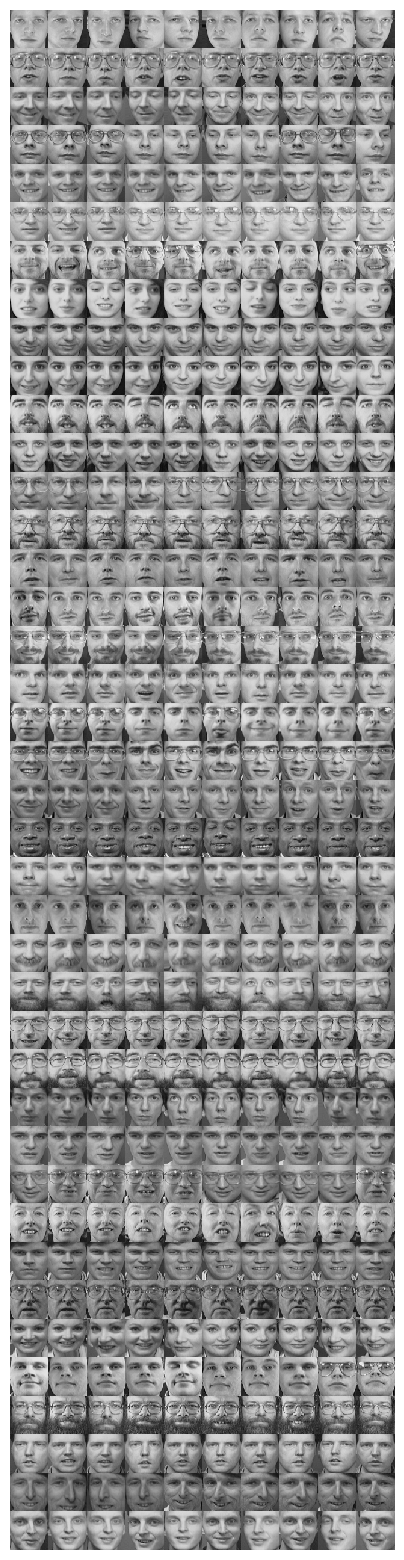

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 20))
ax.imshow(montage(images[..., 0], grid_shape=(40, 10)), cmap="gray", interpolation="none")
ax.axis("off")

## Preprocess Dataset

In [11]:
X_raw = dataset.images
y_raw = dataset.target

X_rgb = gray2rgb(X_raw)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_rgb,
    y_raw,
    train_size=0.70,
    random_state=1234,
    stratify=y_raw,
)

In [13]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (280, 64, 64, 3)
y_train: (280,)
X_test: (120, 64, 64, 3)
y_test: (120,)


In [14]:
y_train_counts = Counter(y_train)
y_test_counts = Counter(y_test)

for i in range(40):
    n_train = y_train_counts.get(i, 0)
    n_test = y_test_counts.get(i, 0)
    print(f"Label: {i:>2} => train: {n_train:>2}, test: {n_test:>2}")

Label:  0 => train:  7, test:  3
Label:  1 => train:  7, test:  3
Label:  2 => train:  7, test:  3
Label:  3 => train:  7, test:  3
Label:  4 => train:  7, test:  3
Label:  5 => train:  7, test:  3
Label:  6 => train:  7, test:  3
Label:  7 => train:  7, test:  3
Label:  8 => train:  7, test:  3
Label:  9 => train:  7, test:  3
Label: 10 => train:  7, test:  3
Label: 11 => train:  7, test:  3
Label: 12 => train:  7, test:  3
Label: 13 => train:  7, test:  3
Label: 14 => train:  7, test:  3
Label: 15 => train:  7, test:  3
Label: 16 => train:  7, test:  3
Label: 17 => train:  7, test:  3
Label: 18 => train:  7, test:  3
Label: 19 => train:  7, test:  3
Label: 20 => train:  7, test:  3
Label: 21 => train:  7, test:  3
Label: 22 => train:  7, test:  3
Label: 23 => train:  7, test:  3
Label: 24 => train:  7, test:  3
Label: 25 => train:  7, test:  3
Label: 26 => train:  7, test:  3
Label: 27 => train:  7, test:  3
Label: 28 => train:  7, test:  3
Label: 29 => train:  7, test:  3
Label: 30 

## Train Model

In [15]:
class CustomPreprocessor:
    def __init__(self, step_fn: Callable) -> None:
        self._step_fn = step_fn

    def fit(self, *args):
        return self

    def transform(self, X):
        return self._step_fn(X)

In [16]:
X_rgb.shape

(400, 64, 64, 3)

In [17]:
to_grayscale = CustomPreprocessor(rgb2gray)
to_flatten = CustomPreprocessor(lambda x: x.reshape(x.shape[0], -1))

In [18]:
pipeline = Pipeline(
    [
        ("GrayScale", to_grayscale),
        ("Flatten", to_flatten),
        ("Normalize", Normalizer()),
        ("MLP", MLPClassifier(activation="relu", alpha=1e-7, epsilon=1e-6, hidden_layer_sizes=(800, 120), random_state=42))
    ]
)

In [19]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('GrayScale',
                 <__main__.CustomPreprocessor object at 0x7fd24101f790>),
                ('Flatten',
                 <__main__.CustomPreprocessor object at 0x7fd24101fca0>),
                ('Normalize', Normalizer()),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=42))])

In [20]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

In [21]:
report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print("==> Train")
print(report_train)
print()
print("==> Test")
print(report_test)

==> Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         7
           8       0.88      1.00      0.93         7
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         7
          17     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Interpretation

In [24]:
explainer = lime_image.LimeImageExplainer()

In [37]:
"""
available algorithm:
- quickshift
- slic
- felzenszwalb
"""

segmenter = SegmentationAlgorithm(
    algo_type="slic",
    n_segments=100,
    compactness=1,
    sigma=1,
)

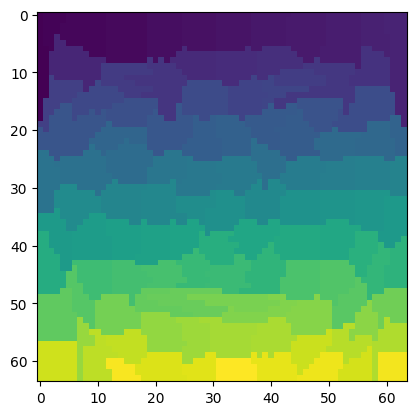

In [38]:
plt.imshow(segmenter.target_fn(X_rgb[0]))